# evaluation test with ALBEF for VQA

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import
import argparse
import os
import ruamel.yaml as yaml
import numpy as np
import random
import time
import datetime
import json
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.distributed as dist

from models.model_vqa import ALBEF
from models.vit import interpolate_pos_embed
from models.tokenization_bert import BertTokenizer

import utils
from dataset.utils import save_result
from dataset import create_dataset, create_sampler, create_loader, vqa_collate_fn

from scheduler import create_scheduler
from optim import create_optimizer

/home/jason/miniconda3/envs/albef/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Data
## follow instruction in vqa_setup.md to download data zip files

In [3]:
# prep data
unzipped = True
VQA_DATA_DIR = 'data'
VQA_PRETRAINEDMODEL_DIR = 'pretrained/vqa'

# Ensure the directories exist
os.makedirs(VQA_DATA_DIR, exist_ok=True)
os.makedirs(VQA_PRETRAINEDMODEL_DIR, exist_ok=True)
if not unzipped:
    import os
    import zipfile

    # prep downloaded data


    zip_files = [
        'train2014.zip',
        'test2015.zip',        
        'val2014.zip',
        'data.tar.gz'
    ]

    for zip_file in zip_files:
        zip_path = os.path.join(VQA_DATA_DIR, zip_file)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(VQA_DATA_DIR)
    print('Unzipped all files.')
    


In [4]:
# show data info and example
# open v2_mscoco_train2014_annotations.json file to illustrate the structure
with open(os.path.join(VQA_DATA_DIR, 'vqa_train.json'), 'r') as f:
    data = json.load(f)


In [5]:
from pprint import pprint
check_idx = 10
pprint(data[check_idx])
print(f'data size: {len(data)}')

{'answer': ['yes',
            'yes',
            'yes',
            'yes',
            'yes',
            'yes',
            'yes',
            'yes',
            'yes',
            'yes'],
 'dataset': 'vqa',
 'image': 'train2014/COCO_train2014_000000393221.jpg',
 'question': 'Is the sky blue?',
 'question_id': 393221000}
data size: 443752


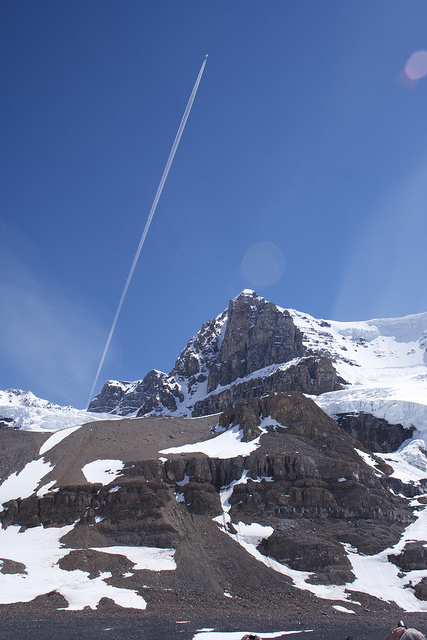

In [6]:
from PIL import Image

# find the corresponding image file for the first annotation
# display it
import matplotlib.pyplot as plt

# Get the image ID from the first annotation
image_filename = data[check_idx]['image']
image_path = os.path.join(VQA_DATA_DIR, image_filename)

# Open and display the image
image = Image.open(image_path)
image



In [7]:
# check the answer list
with open(os.path.join(VQA_DATA_DIR, 'answer_list.json'), 'r') as f:
    answer_list = json.load(f)
print(f'answer_list size: {len(answer_list)}')

answer_list size: 3128


# adapt from VQA.py and ALBEF.ipynb

In [8]:
# set up VQA model to run evaluation
def train(model, data_loader, optimizer, tokenizer, epoch, warmup_steps, device, scheduler, config):
    # train
    model.train()

    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    metric_logger.add_meter('loss', utils.SmoothedValue(window_size=1, fmt='{value:.4f}'))

    header = 'Train Epoch: [{}]'.format(epoch)
    print_freq = 50
    step_size = 100
    warmup_iterations = warmup_steps*step_size

    for i,(image, question, answer, weights, n) in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        image, weights = image.to(device,non_blocking=True), weights.to(device,non_blocking=True)
        question_input = tokenizer(question, padding='longest', truncation=True, max_length=25, return_tensors="pt").to(device)
        answer_input = tokenizer(answer, padding='longest', return_tensors="pt").to(device)

        if epoch>0 or not config['warm_up']:
            alpha = config['alpha']
        else:
            alpha = config['alpha']*min(1,i/len(data_loader))

        loss = model(image, question_input, answer_input, train=True, alpha=alpha, k=n, weights=weights)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metric_logger.update(loss=loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

        if epoch==0 and i%step_size==0 and i<=warmup_iterations:
            scheduler.step(i//step_size)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger.global_avg())
    return {k: "{:.3f}".format(meter.global_avg) for k, meter in metric_logger.meters.items()}

In [9]:
@torch.no_grad()
def evaluation(model, data_loader, tokenizer, device, config) :
    # test
    model.eval()

    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Generate VQA test result:'
    print_freq = 50

    result = []

    answer_list = [answer+config['eos'] for answer in data_loader.dataset.answer_list]
    answer_input = tokenizer(answer_list, padding='longest', return_tensors='pt').to(device)

    for n, (image, question, question_id) in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        image = image.to(device,non_blocking=True)
        question_input = tokenizer(question, padding='longest', return_tensors="pt").to(device)

        topk_ids, topk_probs = model(image, question_input, answer_input, train=False, k=config['k_test'])

        for ques_id, topk_id, topk_prob in zip(question_id, topk_ids, topk_probs):
            ques_id = int(ques_id.item())
            _, pred = topk_prob.max(dim=0)
            result.append({"question_id":ques_id, "answer":data_loader.dataset.answer_list[topk_id[pred]]})

    return result

In [ ]:
# set up VQA config for evaluation
args = argparse.Namespace()
args.config = './configs/VQA.yaml'
args.checkpoint = './pretrained/vqa/vqa.pth' # vqa.pth './ALBEF_4M.pth' # use where you saved the checkpoint
args.output_dir = './output/vqa'
args.evaluate = True # change to True to evaluate or False to train
args.text_encoder = 'bert-base-uncased'
args.text_decoder = 'bert-base-uncased'
args.device = 'cuda'
args.distill = False # False  True
args.seed = 42
args.distributed = False

config = yaml.load(open(args.config, 'r'), Loader=yaml.Loader)
print(args)

Namespace(config='./configs/VQA.yaml', checkpoint='./pretrained/vqa/vqa.pth', output_dir='./output/vqa', evaluate=True, text_encoder='bert-base-uncased', text_decoder='bert-base-uncased', device='cuda', distill=False, seed=42, distributed=False)


In [11]:
args.result_dir = os.path.join(args.output_dir, 'result')

Path(args.output_dir).mkdir(parents=True, exist_ok=True)
Path(args.result_dir).mkdir(parents=True, exist_ok=True)

yaml.dump(config, open(os.path.join(args.output_dir, 'config.yaml'), 'w'))

In [12]:
# prep
utils.init_distributed_mode(args)    

device = torch.device(args.device)

# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = True

Not using distributed mode


In [13]:
tokenizer = BertTokenizer.from_pretrained(args.text_encoder)


/home/jason/miniconda3/envs/albef/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
#### Model #### 
print("Creating model")
model = ALBEF(config=config, text_encoder=args.text_encoder, text_decoder=args.text_decoder, tokenizer=tokenizer)
model = model.to(device)

Creating model


/home/jason/miniconda3/envs/albef/lib/python3.11/site-packages/transformers/modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint

In [113]:
args.checkpoint

'./pretrained/vqa/vqa.pth'

In [16]:
# load vqa checkpoint
if args.checkpoint:    
    checkpoint = torch.load(args.checkpoint, map_location='cpu') 
    if args.evaluate:
        state_dict = checkpoint
    else:
        state_dict = checkpoint['model']
    
    # reshape positional embedding to accomodate for image resolution change
    pos_embed_reshaped = interpolate_pos_embed(state_dict['visual_encoder.pos_embed'],model.visual_encoder)         
    state_dict['visual_encoder.pos_embed'] = pos_embed_reshaped   
    
    if not args.evaluate:
        if config['distill']:
            m_pos_embed_reshaped = interpolate_pos_embed(state_dict['visual_encoder_m.pos_embed'],model.visual_encoder_m)   
            state_dict['visual_encoder_m.pos_embed'] = m_pos_embed_reshaped 
            
        for key in list(state_dict.keys()):
            if 'bert' in key:
                encoder_key = key.replace('bert.','')         
                state_dict[encoder_key] = state_dict[key] 
            # intialize text decoder as multimodal encoder (last 6 layers of model.text_encoder)    
            if 'text_encoder' in key:                
                if 'layer' in key:
                    encoder_keys = key.split('.')
                    layer_num = int(encoder_keys[4])
                    if layer_num<6:
                        del state_dict[key]  
                        continue
                    else:
                        decoder_layer_num = (layer_num-6)
                        encoder_keys[4] = str(decoder_layer_num)
                        encoder_key = '.'.join(encoder_keys)     
                else:
                    encoder_key = key
                decoder_key = encoder_key.replace('text_encoder','text_decoder')  
                state_dict[decoder_key] = state_dict[key]     

                del state_dict[key]                
            
    msg = model.load_state_dict(state_dict,strict=False)  
    print('load checkpoint from %s'%args.checkpoint)
    print(msg)
    print("Missing keys:")
    pprint(msg.missing_keys)
    print("Unexpected keys:", msg.unexpected_keys)

/tmp/ipykernel_51217/4079063331.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.checkpoint, map_location='cpu')


load checkpoint from ./pretrained/vqa/vqa.pth
_IncompatibleKeys(missing_keys=['visual_encoder_m.cls_token', 'visual_encoder_m.pos_embed', 'visual_encoder_m.patch_embed.proj.weight', 'visual_encoder_m.patch_embed.proj.bias', 'visual_encoder_m.blocks.0.norm1.weight', 'visual_encoder_m.blocks.0.norm1.bias', 'visual_encoder_m.blocks.0.attn.qkv.weight', 'visual_encoder_m.blocks.0.attn.qkv.bias', 'visual_encoder_m.blocks.0.attn.proj.weight', 'visual_encoder_m.blocks.0.attn.proj.bias', 'visual_encoder_m.blocks.0.norm2.weight', 'visual_encoder_m.blocks.0.norm2.bias', 'visual_encoder_m.blocks.0.mlp.fc1.weight', 'visual_encoder_m.blocks.0.mlp.fc1.bias', 'visual_encoder_m.blocks.0.mlp.fc2.weight', 'visual_encoder_m.blocks.0.mlp.fc2.bias', 'visual_encoder_m.blocks.1.norm1.weight', 'visual_encoder_m.blocks.1.norm1.bias', 'visual_encoder_m.blocks.1.attn.qkv.weight', 'visual_encoder_m.blocks.1.attn.qkv.bias', 'visual_encoder_m.blocks.1.attn.proj.weight', 'visual_encoder_m.blocks.1.attn.proj.bias', 'v

# single image evaluation

In [17]:
# prepare inputs
with open(os.path.join(VQA_DATA_DIR, 'answer_list.json'), 'r') as f:
    answer_list = json.load(f)
answer_list = [answer+config['eos'] for answer in answer_list]
print(f'answer_list example: {answer_list[0]}')

answer_input = tokenizer(answer_list, padding='longest', return_tensors='pt').to(device)



answer_list example: net[SEP]


In [ ]:
# set up transform for images
from torchvision import transforms
from dataset.randaugment import RandomAugment


config
normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

train_transform = transforms.Compose([                        
        transforms.RandomResizedCrop(config['image_res'],scale=(0.5, 1.0), interpolation=Image.BICUBIC),
        transforms.RandomHorizontalFlip(),
        RandomAugment(2,7,isPIL=True,augs=['Identity','AutoContrast','Equalize','Brightness','Sharpness',
                                            'ShearX', 'ShearY', 'TranslateX', 'TranslateY', 'Rotate']),     
        transforms.ToTensor(),
        normalize,
    ]) 

test_transform = transforms.Compose([
    transforms.Resize((config['image_res'],config['image_res']),interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    normalize,
    ])  


In [55]:
# fetch one image and prep for model evaluation

result = []

check_idx = 55 # index number used to fetch one image
image_filename = data[check_idx]['image']
image_path = os.path.join(VQA_DATA_DIR, image_filename)

# Open and display the image
image = Image.open(image_path).convert('RGB')
image = test_transform(image).unsqueeze(0) # add batch dimension

question = data[check_idx]['question']
question_id = data[check_idx]['question_id']

image = image.to(device,non_blocking=True)
question_input = tokenizer(question, padding='longest', return_tensors="pt").to(device)

In [56]:
# run model evaluation
topk_ids, topk_probs = model(image, question_input, answer_input, train=False, k=config['k_test'])


In [57]:
ques_id, topk_id, topk_prob = question_id, topk_ids[0], topk_probs[0] 
# get the first element since we have only one image


In [58]:
# ques_id = int(ques_id.item())
_, pred = topk_prob.max(dim=0)
print(f'pred: {pred}')


pred: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.0748837].


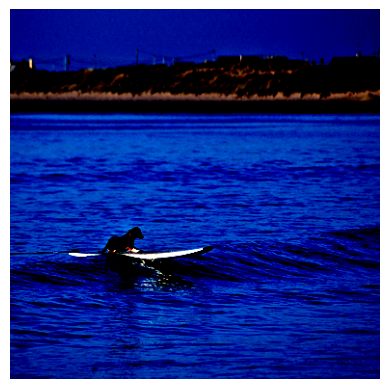

Is there a body of water here? 
question_id:131087003, answer:yes[SEP]


In [ ]:
# show result
plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()
print(f'{question} \nquestion_id:{ques_id}, answer:{answer_list[topk_id[pred]]}')